# PERSONALISED HEALTHCARE RECOMMENDATION SYSTEM FOR ICU PATIENTS

### Loading datasets

In [5]:
import pandas as pd

datasets = {
    "patients": pd.read_csv("patients.csv"),
    "ADMISSIONS": pd.read_csv("ADMISSIONS.csv"),
    "ICUSTAYS": pd.read_csv("ICUSTAYS.csv"),
    "CHARTEVENTS": pd.read_csv("CHARTEVENTS.csv"),
    "LABEVENTS": pd.read_csv("LABEVENTS.csv"),
    "PRESCRIPTIONS": pd.read_csv("PRESCRIPTIONS.csv"),
    "DIAGNOSES_ICD": pd.read_csv("DIAGNOSES_ICD.csv"),
    "NOTEEVENTS": pd.read_csv("NOTEEVENTS.csv"),
    "CPTEVENTS": pd.read_csv("CPTEVENTS.csv"),
    "OUTPUTEVENTS": pd.read_csv("OUTPUTEVENTS.csv"),
}

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/3700576556.py:7: DtypeWarning: Columns (8,10,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  "CHARTEVENTS": pd.read_csv("CHARTEVENTS.csv"),
/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/3700576556.py:9: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  "PRESCRIPTIONS": pd.read_csv("PRESCRIPTIONS.csv"),
/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/3700576556.py:12: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  "CPTEVENTS": pd.read_csv("CPTEVENTS.csv"),


### Importing all the required libraries

In [6]:
# General purpose libraries
import os
import re
import sys
import subprocess
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

# Clustering and NLP
from sklearn.cluster import KMeans
import spacy

# Model persistence
import joblib

In [8]:
# Dataset Information
def display_dataset_info(df, name):
    print(f"\n {name} Dataset")
    print(f"Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nMissing Values:")
    print(df.isnull().sum())
    print("-" * 50)
    
for name, df in datasets.items():  # Looping through each dataset and display info
    display_dataset_info(df, name)



 patients Dataset
Shape: (10000, 8)

First 5 rows:
   ROW_ID  SUBJECT_ID GENDER                  DOB                  DOD  \
0       1           2      M  2138-07-17 00:00:00                  NaN   
1       2           3      M  2025-04-11 00:00:00  2102-06-14 00:00:00   
2       3           4      F  2143-05-12 00:00:00                  NaN   
3       4           5      M  2103-02-02 00:00:00                  NaN   
4       5           6      F  2109-06-21 00:00:00                  NaN   

  DOD_HOSP              DOD_SSN  EXPIRE_FLAG  
0      NaN                  NaN            0  
1      NaN  2102-06-14 00:00:00            1  
2      NaN                  NaN            0  
3      NaN                  NaN            0  
4      NaN                  NaN            0  

Missing Values:
ROW_ID            0
SUBJECT_ID        0
GENDER            0
DOB               0
DOD            6239
DOD_HOSP       7808
DOD_SSN        6562
EXPIRE_FLAG       0
dtype: int64
-------------------------------

## DATA CLEANING

In [9]:
# Data Cleaning
patients = datasets["patients"]
# Converting datetime columns
patients['DOB'] = pd.to_datetime(patients['DOB'])
patients['DOD'] = pd.to_datetime(patients['DOD'], errors='coerce')
patients['DOD_HOSP'] = pd.to_datetime(patients['DOD_HOSP'], errors='coerce')
patients['DOD_SSN'] = pd.to_datetime(patients['DOD_SSN'], errors='coerce')
# Filling missing values
patients['DOD_HOSP'] = patients['DOD_HOSP'].fillna("Alive")
patients['DOD_SSN'] = patients['DOD_SSN'].fillna("Alive")


In [10]:
# ADMISSIONS.csv
admissions = datasets["ADMISSIONS"]
# Convert datetime columns
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
admissions['DEATHTIME'] = pd.to_datetime(admissions['DEATHTIME'], errors='coerce')

# Filling missing values
admissions['LANGUAGE'] = admissions['LANGUAGE'].fillna("Unknown")
admissions['MARITAL_STATUS'] = admissions['MARITAL_STATUS'].fillna("Unknown")
admissions['EDREGTIME'] = pd.to_datetime(admissions['EDREGTIME'], errors='coerce')
admissions['EDOUTTIME'] = pd.to_datetime(admissions['EDOUTTIME'], errors='coerce')

In [11]:
icustays = datasets["ICUSTAYS"]

# Convert datetime columns
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])

In [12]:
#CHARTEVENTS.csv
chartevents = datasets["CHARTEVENTS"]
# Converting datetime columns
chartevents['charttime'] = pd.to_datetime(chartevents['charttime'])
chartevents['storetime'] = pd.to_datetime(chartevents['storetime'], errors='coerce')
chartevents = chartevents.dropna(subset=['valuenum'])
chartevents = chartevents.drop(columns=['warning', 'error', 'resultstatus', 'stopped'])

In [13]:
#LABEVENTS.csv
labevents = datasets["LABEVENTS"]
labevents = labevents.dropna(subset=['HADM_ID']) # Drop rows with missing vals
labevents['CHARTTIME'] = pd.to_datetime(labevents['CHARTTIME'])
labevents = labevents.dropna(subset=['VALUENUM'])
labevents = labevents.drop(columns=['VALUEUOM', 'FLAG'])

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/1670203922.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labevents['CHARTTIME'] = pd.to_datetime(labevents['CHARTTIME'])


In [14]:
print("Available columns in LABEVENTS:", labevents.columns)
columns_to_drop = ['VALUEUNOM', 'flag']
existing_columns = [col for col in columns_to_drop if col in labevents.columns]
labevents = labevents.drop(columns=existing_columns)

Available columns in LABEVENTS: Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUE',
       'VALUENUM'],
      dtype='object')


In [19]:
columns_to_drop = ['VALUEUOM', 'FLAG'] # Dropping columns using correct names
existing_columns = [col for col in columns_to_drop if col in labevents.columns]
labevents = labevents.drop(columns=existing_columns)

In [20]:
patients.to_csv('PATIENTS_cleaned.csv', index=False)
admissions.to_csv('ADMISSIONS_cleaned.csv', index=False)
icustays.to_csv('ICUSTAYS_cleaned.csv', index=False)
chartevents.to_csv('CHARTEVENTS_cleaned.csv', index=False)
labevents.to_csv('LABEVENTS_cleaned.csv', index=False)

In [21]:
merged_data = pd.merge(patients, admissions, on='SUBJECT_ID', how='inner')
merged_data = pd.merge(merged_data, icustays, on=['SUBJECT_ID', 'HADM_ID'], how='inner')
merged_data.to_csv('MERGED_DATA.csv', index=False)

In [22]:
merged_data['AGE'] = (merged_data['ADMITTIME'].dt.year - merged_data['DOB'].dt.year)
merged_data['LOS_DAYS'] = (merged_data['DISCHTIME'] - merged_data['ADMITTIME']).dt.days
merged_data['ADMIT_HOUR'] = merged_data['ADMITTIME'].dt.hour
merged_data['ADMIT_DAYOFWEEK'] = merged_data['ADMITTIME'].dt.day_name()
merged_data.to_csv('MERGED_DATA_cleaned_final.csv', index=False)

In [23]:
def check_null_values(df, name):
    print(f"\n===== Null Values in {name} =====")
    print(df.isnull().sum())
patients_cleaned = pd.read_csv('PATIENTS_cleaned.csv')
admissions_cleaned = pd.read_csv('ADMISSIONS_cleaned.csv')
icustays_cleaned = pd.read_csv('ICUSTAYS_cleaned.csv')
chartevents_cleaned = pd.read_csv('CHARTEVENTS_cleaned.csv')
labevents_cleaned = pd.read_csv('LABEVENTS_cleaned.csv')
merged_data = pd.read_csv('MERGED_DATA_cleaned_final.csv')


check_null_values(patients_cleaned, "PATIENTS")
check_null_values(admissions_cleaned, "ADMISSIONS")
check_null_values(icustays_cleaned, "ICUSTAYS")
check_null_values(chartevents_cleaned, "CHARTEVENTS")
check_null_values(labevents_cleaned, "LABEVENTS")
check_null_values(merged_data, "MERGED_DATA")

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/3168275414.py:7: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  chartevents_cleaned = pd.read_csv('CHARTEVENTS_cleaned.csv')



===== Null Values in PATIENTS =====
ROW_ID            0
SUBJECT_ID        0
GENDER            0
DOB               0
DOD            6239
DOD_HOSP          0
DOD_SSN           0
EXPIRE_FLAG       0
dtype: int64

===== Null Values in ADMISSIONS =====
ROW_ID                      0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               11624
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                    0
RELIGION                  183
MARITAL_STATUS              0
ETHNICITY                   0
EDREGTIME                6979
EDOUTTIME                6979
DIAGNOSIS                   8
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
dtype: int64

===== Null Values in ICUSTAYS =====
ROW_ID            0
SUBJECT_ID        0
HADM_ID           0
ICUSTAY_ID        0
DBSOURCE          0
FIRST_CAREUNIT    0
LAST_CAREUN

In [24]:
admissions['DEATHTIME'] = admissions['DEATHTIME'].fillna("Alive")
admissions['RELIGION'] = admissions['RELIGION'].fillna("Unknown")
admissions = admissions.dropna(subset=['EDREGTIME', 'EDOUTTIME'])
admissions.to_csv('ADMISSIONS_cleaned_final.csv', index=False)
chartevents = chartevents.dropna(subset=['icustay_id'])
chartevents = chartevents.dropna(subset=['value'])
chartevents.to_csv('CHARTEVENTS_cleaned_final.csv', index=False)
merged_data['DEATHTIME'] = merged_data['DEATHTIME'].fillna("Alive")
merged_data['RELIGION'] = merged_data['RELIGION'].fillna("Unknown")
merged_data = merged_data.dropna(subset=['EDREGTIME', 'EDOUTTIME'])
merged_data.to_csv('MERGED_DATA_cleaned_final.csv', index=False)

In [25]:
def check_null_values(df, name):
    print(f"\n===== Null Values in {name} =====")
    print(df.isnull().sum())

admissions_cleaned = pd.read_csv('ADMISSIONS_cleaned_final.csv')
chartevents_cleaned = pd.read_csv('CHARTEVENTS_cleaned_final.csv')
merged_data = pd.read_csv('MERGED_DATA_cleaned_final.csv')

check_null_values(admissions_cleaned, "ADMISSIONS")
check_null_values(chartevents_cleaned, "CHARTEVENTS")
check_null_values(merged_data, "MERGED_DATA")


===== Null Values in ADMISSIONS =====
ROW_ID                  0
SUBJECT_ID              0
HADM_ID                 0
ADMITTIME               0
DISCHTIME               0
DEATHTIME               0
ADMISSION_TYPE          0
ADMISSION_LOCATION      0
DISCHARGE_LOCATION      0
INSURANCE               0
LANGUAGE                0
RELIGION                0
MARITAL_STATUS          0
ETHNICITY               0
EDREGTIME               0
EDOUTTIME               0
DIAGNOSIS               0
HOSPITAL_EXPIRE_FLAG    0
HAS_CHARTEVENTS_DATA    0
dtype: int64

===== Null Values in CHARTEVENTS =====
row_id            0
subject_id        0
hadm_id           0
icustay_id        0
itemid            0
charttime         0
storetime         0
cgid              0
value             0
valuenum          0
valueuom      83411
dtype: int64

===== Null Values in MERGED_DATA =====
ROW_ID_x                   0
SUBJECT_ID                 0
GENDER                     0
DOB                        0
DOD                     2

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/2672795853.py:6: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  chartevents_cleaned = pd.read_csv('CHARTEVENTS_cleaned_final.csv')


In [26]:
merged_data = pd.merge(patients, admissions, on='SUBJECT_ID', how='inner')
merged_data = pd.merge(merged_data, icustays, on=['SUBJECT_ID', 'HADM_ID'], how='inner')


merged_data['AGE'] = (merged_data['ADMITTIME'].dt.year - merged_data['DOB'].dt.year)
merged_data['LOS_DAYS'] = (merged_data['DISCHTIME'] - merged_data['ADMITTIME']).dt.days
merged_data['ADMIT_HOUR'] = merged_data['ADMITTIME'].dt.hour
merged_data['ADMIT_DAYOFWEEK'] = merged_data['ADMITTIME'].dt.day_name()


patients.to_csv("PATIENTS_cleaned.csv", index=False)
admissions.to_csv("ADMISSIONS_cleaned.csv", index=False)
icustays.to_csv("ICUSTAYS_cleaned.csv", index=False)
chartevents.to_csv("CHARTEVENTS_cleaned.csv", index=False)
labevents.to_csv("LABEVENTS_cleaned.csv", index=False)

merged_data.to_csv("MERGED_DATA_cleaned_final.csv", index=False)

In [27]:
file_path = "MERGED_DATA_cleaned_final.csv"
merged_data = pd.read_csv(file_path)

datetime_cols = ["DOD", "DEATHTIME", "OUTTIME", "ADMITTIME", "DISCHTIME", "EDREGTIME", "EDOUTTIME"]
for col in datetime_cols:
    merged_data[col] = pd.to_datetime(merged_data[col], errors='coerce')

merged_data['DOD'].fillna("Alive", inplace=True)
merged_data['DEATHTIME'].fillna("Alive", inplace=True)


merged_data['OUTTIME'].fillna(merged_data['OUTTIME'].median(), inplace=True)
merged_data['LOS'].fillna(merged_data['LOS'].median(), inplace=True)

cleaned_file_path = "MERGED_DATA_cleaned_final.csv"
merged_data.to_csv(cleaned_file_path, index=False)

print(merged_data.isnull().sum())

ROW_ID_x                0
SUBJECT_ID              0
GENDER                  0
DOB                     0
DOD                     0
DOD_HOSP                0
DOD_SSN                 0
EXPIRE_FLAG             0
ROW_ID_y                0
HADM_ID                 0
ADMITTIME               0
DISCHTIME               0
DEATHTIME               0
ADMISSION_TYPE          0
ADMISSION_LOCATION      0
DISCHARGE_LOCATION      0
INSURANCE               0
LANGUAGE                0
RELIGION                0
MARITAL_STATUS          0
ETHNICITY               0
EDREGTIME               0
EDOUTTIME               0
DIAGNOSIS               0
HOSPITAL_EXPIRE_FLAG    0
HAS_CHARTEVENTS_DATA    0
ROW_ID                  0
ICUSTAY_ID              0
DBSOURCE                0
FIRST_CAREUNIT          0
LAST_CAREUNIT           0
FIRST_WARDID            0
LAST_WARDID             0
INTIME                  0
OUTTIME                 0
LOS                     0
AGE                     0
LOS_DAYS                0
ADMIT_HOUR  

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/3583524966.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data[col] = pd.to_datetime(merged_data[col], errors='coerce')
/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/3583524966.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_data['DOD'].fillna("Alive", inplace=True)
/var/folders/k4/8y

### Age Distribution

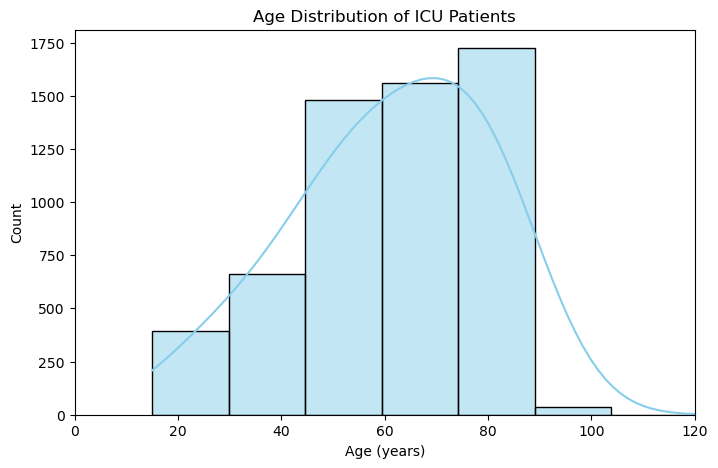

In [28]:
plt.figure(figsize=(8, 5))
sns.histplot(merged_data['AGE'], kde=True, bins=20, color='skyblue')
plt.xlim(0, 120)
plt.title('Age Distribution of ICU Patients')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

### Gender Distribution

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/659684598.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='GENDER', data=merged_data, palette='pastel')


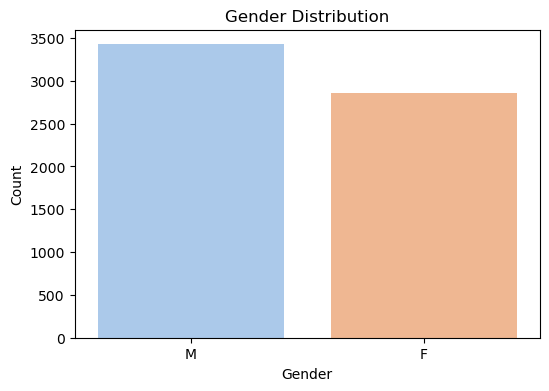

In [29]:
plt.figure(figsize=(6, 4))
sns.countplot(x='GENDER', data=merged_data, palette='pastel')
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

### Mortality

Overall Mortality Rate (all patients): 37.61%


/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/3749707751.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='EXPIRE_FLAG', data=patients, palette='Set2')


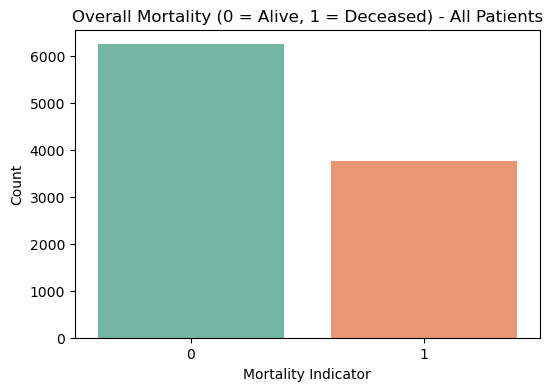

In [32]:
patients = pd.read_csv("PATIENTS_cleaned.csv")
mortality_rate_all = patients['EXPIRE_FLAG'].mean() * 100
print(f"Overall Mortality Rate (all patients): {mortality_rate_all:.2f}%")

# Plot the mortality distribution for all patients
plt.figure(figsize=(6, 4))
sns.countplot(x='EXPIRE_FLAG', data=patients, palette='Set2')
plt.title('Overall Mortality (0 = Alive, 1 = Deceased) - All Patients')
plt.xlabel('Mortality Indicator')
plt.ylabel('Count')
plt.show()

### Ethicity Distribution

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/1577799756.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ETHNICITY', data=merged_data, palette='muted')


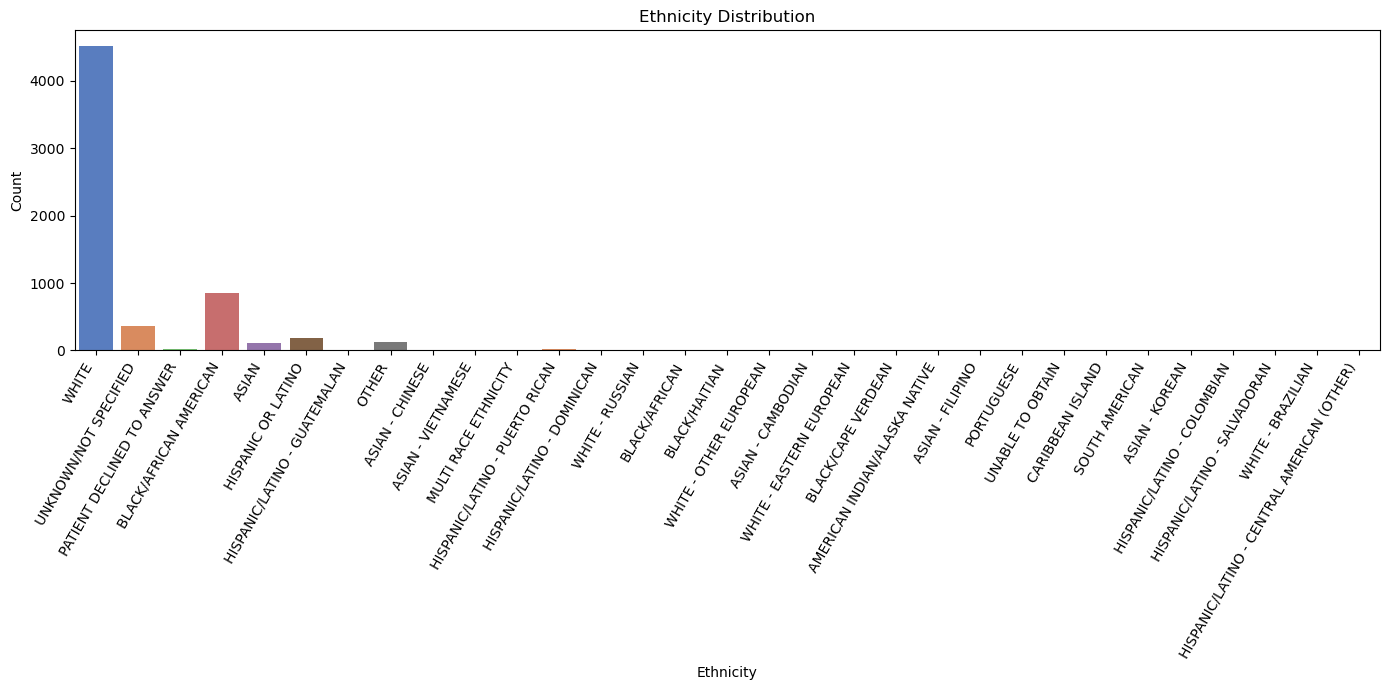

In [34]:
plt.figure(figsize=(14, 7))  
sns.countplot(x='ETHNICITY', data=merged_data, palette='muted')
plt.title('Ethnicity Distribution')
plt.xlabel('Ethnicity')
plt.ylabel('Count')

plt.xticks(rotation=60, ha='right') 
plt.tight_layout()  
plt.show()

### Length of stay

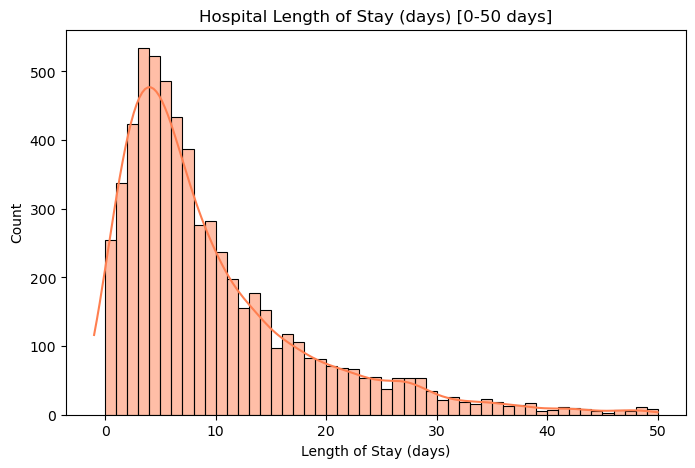

In [35]:
plt.figure(figsize=(8, 5))
filtered_los = merged_data[merged_data['LOS_DAYS'] <= 50]['LOS_DAYS']
bins = range(0, 51, 1)
sns.histplot(filtered_los, 
             kde=True, 
             bins=bins, 
             color='coral')

plt.title('Hospital Length of Stay (days) [0-50 days]')
plt.xlabel('Length of Stay (days)')
plt.ylabel('Count')
plt.show()

### Admission Hour and Day of Week

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/2627751563.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ADMIT_HOUR', data=merged_data, palette='Blues_d')


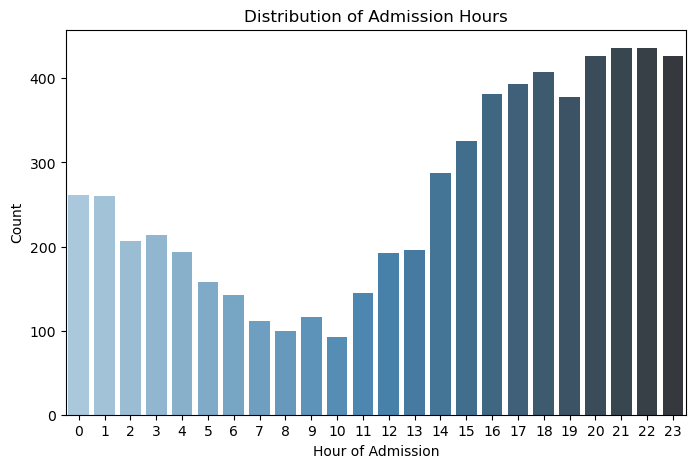

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/2627751563.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ADMIT_DAYOFWEEK', data=merged_data, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='Greens_d')


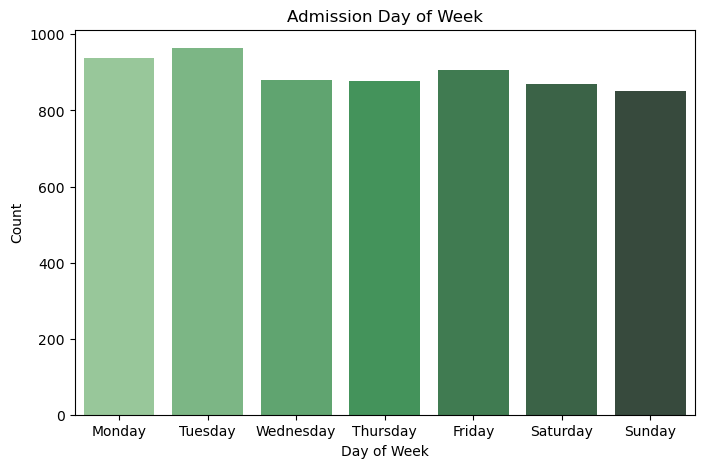

In [36]:
# Admission Hour Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='ADMIT_HOUR', data=merged_data, palette='Blues_d')
plt.title('Distribution of Admission Hours')
plt.xlabel('Hour of Admission')
plt.ylabel('Count')
plt.show()

# Day of Week Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='ADMIT_DAYOFWEEK', data=merged_data, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='Greens_d')
plt.title('Admission Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Count')
plt.show()

### Correlation Heatmap

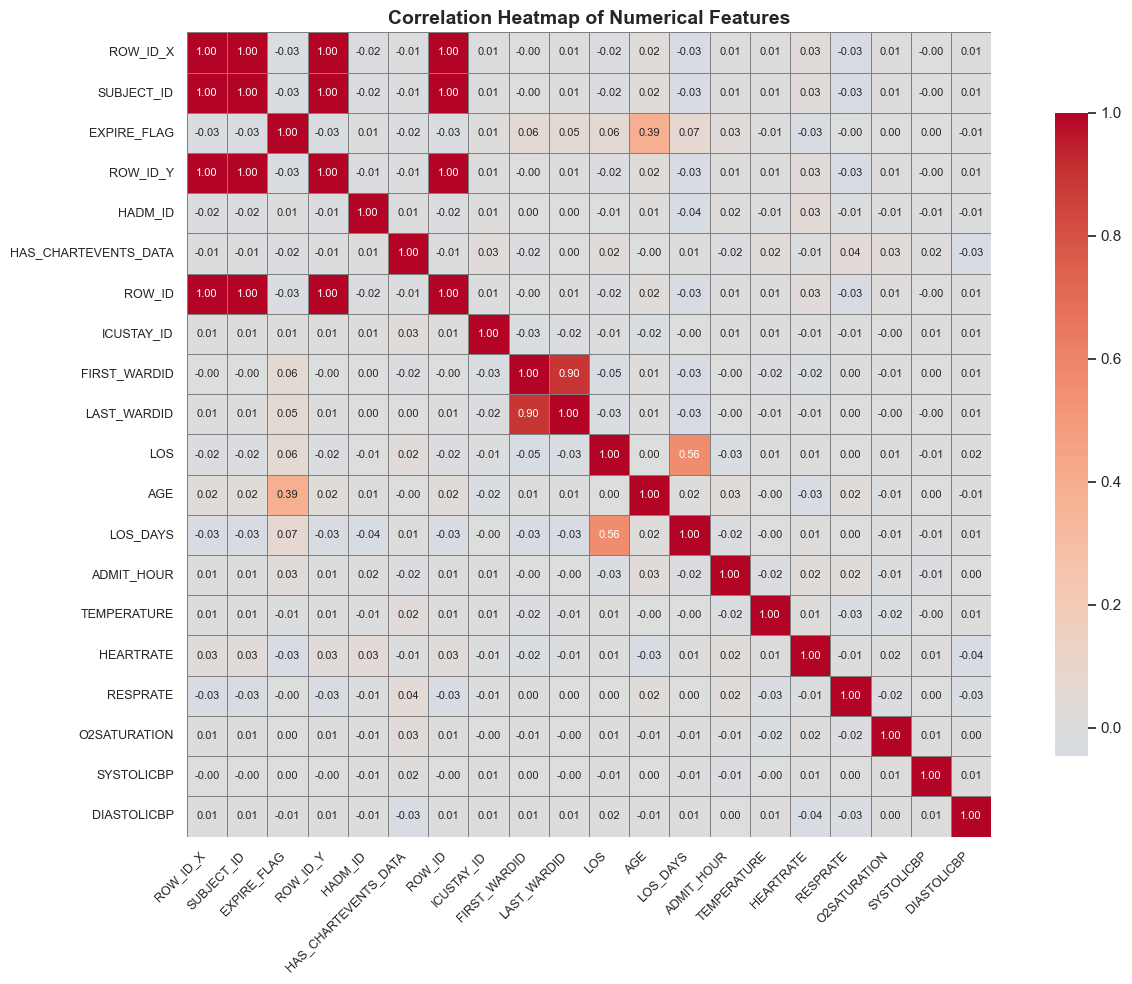

In [37]:
df = pd.read_csv("MERGED_DATA_cleaned_final1.csv")
numerical_features = df.select_dtypes(include=['number'])
corr_matrix = numerical_features.corr()
plt.figure(figsize=(14, 10))
sns.set(style="white")

# Creating heatmap
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={"shrink": 0.8},
    annot_kws={"size": 8}
)

plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### Scatter Plot: Age vs. Length of Stay

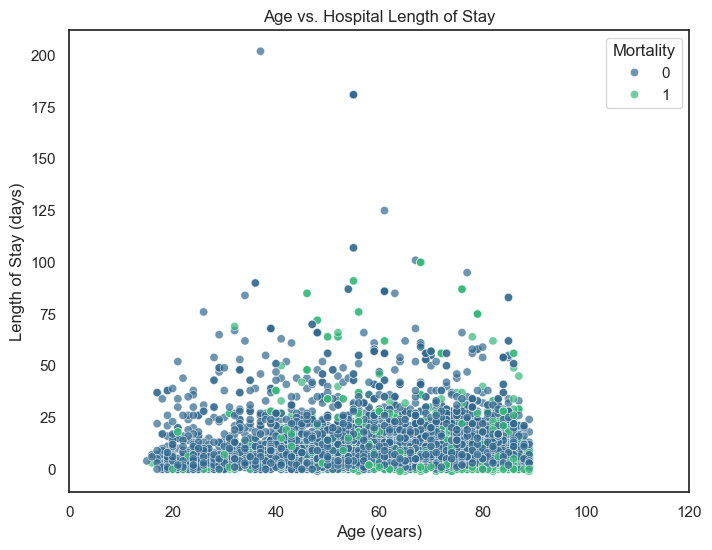

In [38]:
plt.figure(figsize=(8, 6))
filtered_data = merged_data[merged_data['AGE'] <= 150] # Filtering out unrealistic ages (keep only ages ≤ 150)

sns.scatterplot(x='AGE', y='LOS_DAYS', hue='HOSPITAL_EXPIRE_FLAG', data=filtered_data, palette='viridis', alpha=0.7)
plt.title('Age vs. Hospital Length of Stay')
plt.xlabel('Age (years)')
plt.ylabel('Length of Stay (days)')
plt.legend(title='Mortality')
plt.xlim(0, 120)
plt.show()

### Heart Rate Time series

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/3047429474.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  chartevents = pd.read_csv('CHARTEVENTS_cleaned_final.csv', parse_dates=['charttime', 'storetime'])


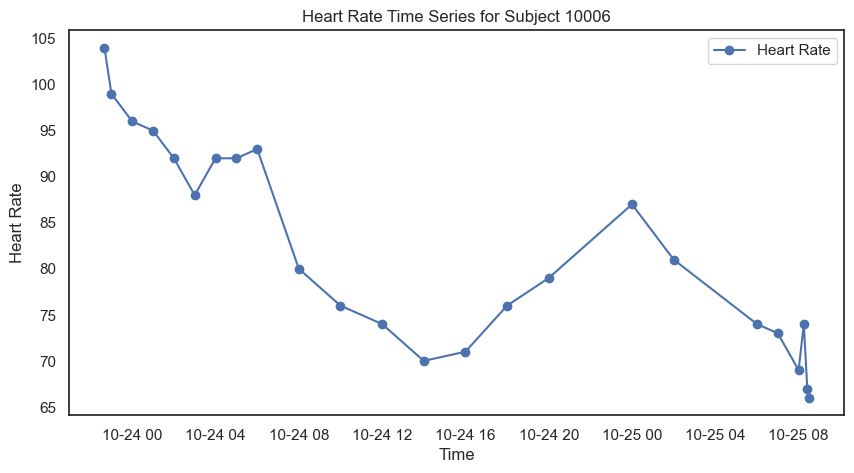

In [39]:
chartevents = pd.read_csv('CHARTEVENTS_cleaned_final.csv', parse_dates=['charttime', 'storetime'])
sample_subject = 10006
heart_rate_itemid = 211

heart_rate_data = chartevents[
    (chartevents['subject_id'] == sample_subject) &
    (chartevents['itemid'] == heart_rate_itemid)
]


plt.figure(figsize=(10, 5))
plt.plot(heart_rate_data['charttime'], heart_rate_data['valuenum'], marker='o', linestyle='-', label='Heart Rate')
plt.xlabel('Time')
plt.ylabel('Heart Rate')
plt.title(f'Heart Rate Time Series for Subject {sample_subject}')
plt.legend()
plt.show()

### Top 10 prescribed Drugs

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/3877910952.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv('PRESCRIPTIONS.csv')
/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/3877910952.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=drug_counts.index, y=drug_counts.values, palette='viridis')


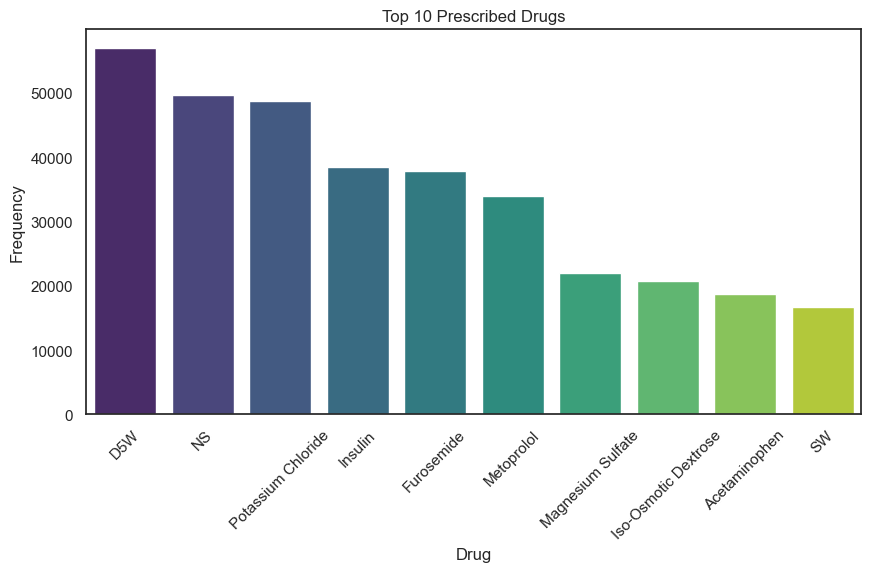

In [40]:
prescriptions = pd.read_csv('PRESCRIPTIONS.csv')
drug_counts = prescriptions['DRUG'].value_counts().head(10)
plt.figure(figsize=(10, 5))
sns.barplot(x=drug_counts.index, y=drug_counts.values, palette='viridis')
plt.xlabel('Drug')
plt.ylabel('Frequency')
plt.title('Top 10 Prescribed Drugs')
plt.xticks(rotation=45)
plt.show()


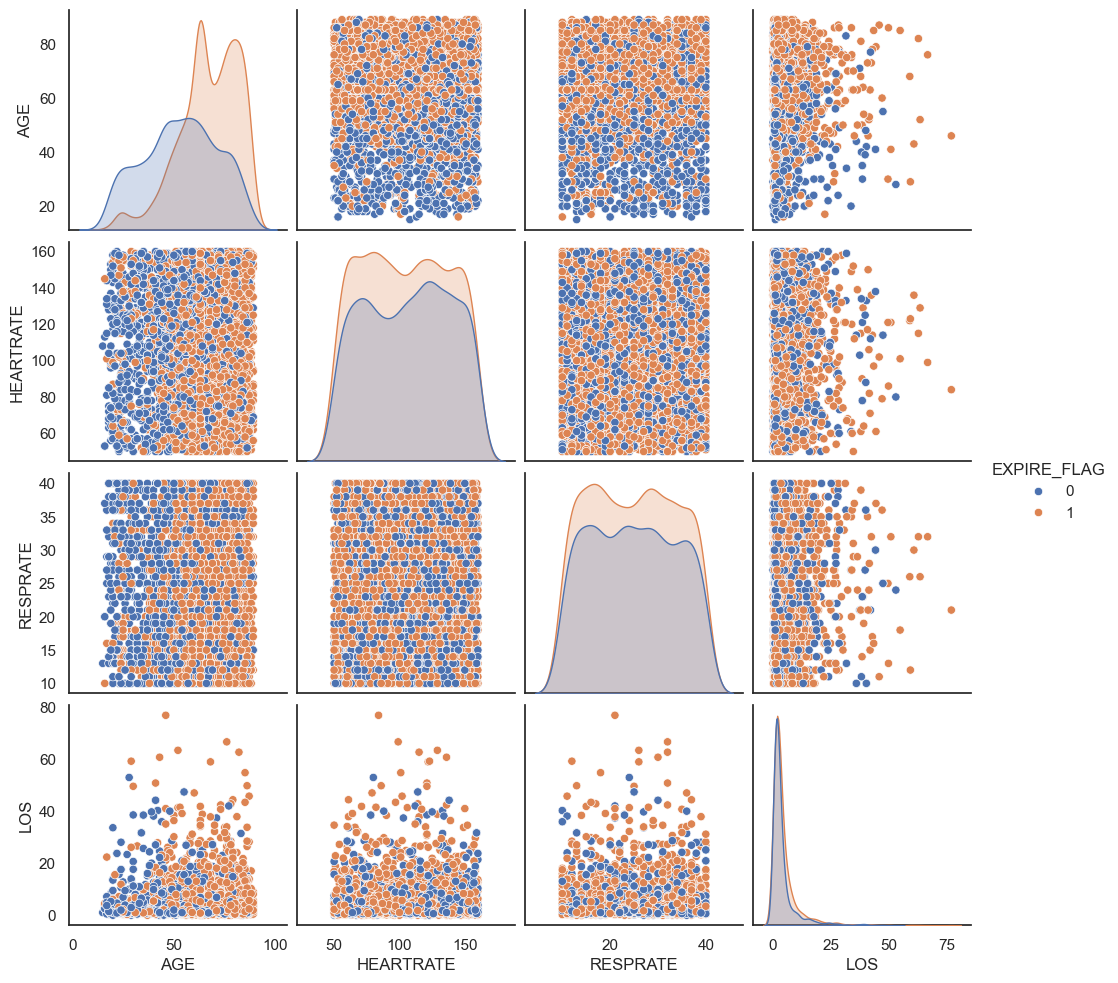

In [41]:
sns.pairplot(df[['AGE', 'HEARTRATE', 'RESPRATE', 'LOS', 'EXPIRE_FLAG']], hue='EXPIRE_FLAG')

## Identifying patients with sepsis

In [42]:
diagnoses = pd.read_csv('DIAGNOSES_ICD.csv')
diagnoses["ICD9_CODE"] = diagnoses["ICD9_CODE"].astype(str)
sepsis_mask = (
    diagnoses["ICD9_CODE"].str.startswith("99591") | 
    diagnoses["ICD9_CODE"].str.startswith("99592") | 
    diagnoses["ICD9_CODE"].str.startswith("78552") | 
    diagnoses["ICD9_CODE"].str.startswith("038")
)
sepsis_diagnoses = diagnoses[sepsis_mask]
sepsis_patients = sepsis_diagnoses["SUBJECT_ID"].unique()
print("Number of unique patients with sepsis diagnosis:", len(sepsis_patients))

Number of unique patients with sepsis diagnosis: 1152


In [43]:
merged_data['ADMITTIME'] = pd.to_datetime(merged_data['ADMITTIME'], errors='coerce')
merged_data['DEATHTIME'] = pd.to_datetime(merged_data['DEATHTIME'], errors='coerce')
death_df = merged_data[merged_data['DEATHTIME'].notna()].copy()
death_df['time_to_death_days'] = (death_df['DEATHTIME'] - death_df['ADMITTIME']).dt.total_seconds() / (24 * 3600)
deaths_within_day = (death_df['time_to_death_days'] <= 1).sum()
deaths_within_week = (death_df['time_to_death_days'] <= 7).sum()
deaths_within_month = (death_df['time_to_death_days'] <= 30).sum()

print("Number of patients who died within 1 day:", deaths_within_day)
print("Number of patients who died within 1 week:", deaths_within_week)
print("Number of patients who died within 1 month:", deaths_within_month)


Number of patients who died within 1 day: 151
Number of patients who died within 1 week: 500
Number of patients who died within 1 month: 909


/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/1692402749.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['DEATHTIME'] = pd.to_datetime(merged_data['DEATHTIME'], errors='coerce')


In [44]:
merged_data = pd.read_csv("MERGED_DATA_cleaned_final.csv", parse_dates=["ADMITTIME", "DISCHTIME", "DOB", "DEATHTIME"])
merged_data['DEATHTIME'] = pd.to_datetime(merged_data['DEATHTIME'], errors='coerce')
merged_data['time_to_death_days'] = (merged_data['DEATHTIME'] - merged_data['ADMITTIME']).dt.total_seconds() / (24 * 3600)
deaths_within_month = merged_data[(merged_data['DEATHTIME'].notna()) & (merged_data['time_to_death_days'] <= 30)]
print("Total number of patients who died within a month:", deaths_within_month.shape[0])
print("\nDescriptive statistics for patients who died within a month:")
print(deaths_within_month[['AGE', 'LOS_DAYS', 'time_to_death_days']].describe())
categorical_vars = ['GENDER', 'ETHNICITY', 'ADMISSION_TYPE', 'DIAGNOSIS']

for var in categorical_vars:
    if var in deaths_within_month.columns:
        print(f"\nValue counts for {var}:")
        print(deaths_within_month[var].value_counts(dropna=False))
other_vars = ['MARITAL_STATUS', 'INSURANCE']
for var in other_vars:
    if var in deaths_within_month.columns:
        print(f"\nValue counts for {var}:")
        print(deaths_within_month[var].value_counts(dropna=False))

Total number of patients who died within a month: 909

Descriptive statistics for patients who died within a month:
              AGE    LOS_DAYS  time_to_death_days
count  909.000000  909.000000          909.000000
mean    96.815182    7.951595            8.423802
std     78.199683    7.897601            8.011878
min     16.000000   -1.000000          -28.077778
25%     59.000000    1.000000            1.813194
50%     75.000000    6.000000            6.150694
75%     84.000000   12.000000           12.829861
max    311.000000   29.000000           29.965972

Value counts for GENDER:
GENDER
M    458
F    451
Name: count, dtype: int64

Value counts for ETHNICITY:
ETHNICITY
WHITE                         674
BLACK/AFRICAN AMERICAN         95
UNKNOWN/NOT SPECIFIED          81
ASIAN                          20
HISPANIC OR LATINO             18
OTHER                          13
PATIENT DECLINED TO ANSWER      2
BLACK/CAPE VERDEAN              2
ASIAN - CAMBODIAN               1
UNABLE TO OB

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/3027560339.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data = pd.read_csv("MERGED_DATA_cleaned_final.csv", parse_dates=["ADMITTIME", "DISCHTIME", "DOB", "DEATHTIME"])
/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/3027560339.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['DEATHTIME'] = pd.to_datetime(merged_data['DEATHTIME'], errors='coerce')


In [45]:
merged_data = pd.read_csv("MERGED_DATA_cleaned_final.csv", parse_dates=["ADMITTIME", "DISCHTIME", "DOB", "DEATHTIME"])
merged_data['DEATHTIME'] = pd.to_datetime(merged_data['DEATHTIME'], errors='coerce')
merged_data['time_to_death_days'] = (merged_data['DEATHTIME'] - merged_data['ADMITTIME']).dt.total_seconds() / (24 * 3600)
sepsis_patients = merged_data[merged_data['DIAGNOSIS'].str.contains("sepsis", case=False, na=False)]
print("Total sepsis patients:", sepsis_patients.shape[0])
sepsis_death = sepsis_patients[
    (sepsis_patients['DEATHTIME'].notna()) &
    (merged_data['time_to_death_days'] <= 30)
]
print("Sepsis patients who died within 30 days:", sepsis_death.shape[0])

sepsis_survived = sepsis_patients[~(
    (sepsis_patients['DEATHTIME'].notna()) &
    (merged_data['time_to_death_days'] <= 30)
)]
print("Sepsis patients who survived beyond 30 days or are alive:", sepsis_survived.shape[0])
num_vars = ['AGE', 'LOS_DAYS', 'time_to_death_days']
print("\n--- Descriptive Statistics for Sepsis Patients Who Died Within 30 Days ---")
print(sepsis_death[num_vars].describe())

print("\n--- Descriptive Statistics for Sepsis Patients Who Did Not Die Within 30 Days ---")
print(sepsis_survived[num_vars].describe())

cat_vars = ['GENDER', 'ETHNICITY', 'ADMISSION_TYPE', 'MARITAL_STATUS', 'INSURANCE']
print("\n--- Frequency Distributions for Sepsis Patients Who Died Within 30 Days ---")
for var in cat_vars:
    if var in sepsis_death.columns:
        print(f"\n{var}:")
        print(sepsis_death[var].value_counts(dropna=False))

print("\n--- Frequency Distributions for Sepsis Patients Who Did Not Die Within 30 Days ---")
for var in cat_vars:
    if var in sepsis_survived.columns:
        print(f"\n{var}:")
        print(sepsis_survived[var].value_counts(dropna=False))

Total sepsis patients: 405
Sepsis patients who died within 30 days: 89
Sepsis patients who survived beyond 30 days or are alive: 316

--- Descriptive Statistics for Sepsis Patients Who Died Within 30 Days ---
              AGE   LOS_DAYS  time_to_death_days
count   89.000000  89.000000           89.000000
mean    98.348315   6.112360            6.611064
std     81.243196   6.747791            6.740915
min     31.000000   0.000000            0.140278
25%     58.000000   1.000000            1.064583
50%     72.000000   3.000000            3.862500
75%     82.000000  11.000000           11.436806
max    306.000000  29.000000           29.793750

--- Descriptive Statistics for Sepsis Patients Who Did Not Die Within 30 Days ---
              AGE    LOS_DAYS  time_to_death_days
count  316.000000  316.000000           11.000000
mean    78.395570   14.044304           61.431061
std     56.814081   16.307889           18.369409
min     22.000000    0.000000           34.606944
25%     53.000000

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/4063875776.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data = pd.read_csv("MERGED_DATA_cleaned_final.csv", parse_dates=["ADMITTIME", "DISCHTIME", "DOB", "DEATHTIME"])
/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/4063875776.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_data['DEATHTIME'] = pd.to_datetime(merged_data['DEATHTIME'], errors='coerce')
/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/4063875776.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sepsis_death = sepsis_patients[
/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/406

## FEATURE ENGINEERING


In [51]:
merged = pd.merge(admissions, patients, on="SUBJECT_ID", how="inner")

In [46]:
patients = pd.read_csv('PATIENTS.csv')
admissions = pd.read_csv('ADMISSIONS.csv')
print("PATIENTS:", patients.shape)
print("ADMISSIONS:", admissions.shape)
print("Missing DOBs:", patients["DOB"].isna().sum())
print("Missing ADMITTIME:", admissions["ADMITTIME"].isna().sum())
merged_raw = pd.merge(admissions, patients, on="SUBJECT_ID", how="inner")
print("Merged rows BEFORE filtering:", merged_raw.shape)
merged_raw["DOB"] = pd.to_datetime(merged_raw["DOB"], errors='coerce')
merged_raw["ADMITTIME"] = pd.to_datetime(merged_raw["ADMITTIME"], errors='coerce')
merged_filtered = merged_raw[
    (merged_raw["DOB"].dt.year >= 1900) & (merged_raw["DOB"].dt.year <= 2024) &
    (merged_raw["ADMITTIME"].dt.year >= 2000) & (merged_raw["ADMITTIME"].dt.year <= 2024)
]

print("Merged rows AFTER filtering:", merged_filtered.shape)
print(merged_filtered[["SUBJECT_ID", "DOB", "ADMITTIME"]].head())


PATIENTS: (10000, 8)
ADMISSIONS: (12911, 19)
Missing DOBs: 0
Missing ADMITTIME: 0
Merged rows BEFORE filtering: (12911, 26)
Merged rows AFTER filtering: (0, 26)
Empty DataFrame
Columns: [SUBJECT_ID, DOB, ADMITTIME]
Index: []


In [47]:
print("PATIENTS:", patients.shape)
print("ADMISSIONS:", admissions.shape)
print("Missing DOBs:", patients["DOB"].isna().sum())
print("Missing ADMITTIME:", admissions["ADMITTIME"].isna().sum())
merged_raw["DOB"] = pd.to_datetime(merged_raw["DOB"], errors='coerce')
merged_raw["ADMITTIME"] = pd.to_datetime(merged_raw["ADMITTIME"], errors='coerce')
merged_filtered = merged_raw[
    (merged_raw["DOB"].dt.year >= 1900) & (merged_raw["DOB"].dt.year <= 2024) &
    (merged_raw["ADMITTIME"].dt.year >= 2000) & (merged_raw["ADMITTIME"].dt.year <= 2024)
]
print("Merged rows AFTER filtering:", merged_filtered.shape)

PATIENTS: (10000, 8)
ADMISSIONS: (12911, 19)
Missing DOBs: 0
Missing ADMITTIME: 0
Merged rows AFTER filtering: (0, 26)


In [48]:
(merged_raw["DOB"].dt.year >= 1900) & (merged_raw["DOB"].dt.year <= 2024)&(merged_raw["ADMITTIME"].dt.year >= 2000) & (merged_raw["ADMITTIME"].dt.year <= 2024)

0        False
1        False
2        False
3        False
4        False
         ...  
12906    False
12907    False
12908    False
12909    False
12910    False
Length: 12911, dtype: bool

In [49]:
patients = pd.read_csv('PATIENTS.csv')
admissions = pd.read_csv('ADMISSIONS.csv')
patients["DOB"] = pd.to_datetime(patients["DOB"], errors="coerce")
admissions["ADMITTIME"] = pd.to_datetime(admissions["ADMITTIME"], errors="coerce")
merged = pd.merge(admissions, patients, on="SUBJECT_ID", how="inner")
merged = merged[(merged["DOB"].dt.year >= 1900) & (merged["DOB"].dt.year <= 2150)]
merged = merged[(merged["ADMITTIME"].dt.year >= 2000) & (merged["ADMITTIME"].dt.year <= 2250)]
merged["AGE"] = merged["ADMITTIME"].dt.year - merged["DOB"].dt.year
merged.loc[(merged["AGE"] < 0) | (merged["AGE"] > 120), "AGE"] = np.nan
merged["AGE"].fillna(merged["AGE"].median(), inplace=True)
print(merged[["SUBJECT_ID", "AGE"]].describe())
print("Number of missing AGE values:", merged["AGE"].isna().sum())

         SUBJECT_ID           AGE
count  10773.000000  10773.000000
mean    5260.868375     54.885362
std     3053.813067     25.684873
min        2.000000      0.000000
25%     2610.000000     45.000000
50%     5261.000000     61.000000
75%     7862.000000     75.000000
max    10566.000000     89.000000
Number of missing AGE values: 0


/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/2348647360.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged["AGE"].fillna(merged["AGE"].median(), inplace=True)


In [50]:
data = admissions.merge(patients, on="SUBJECT_ID", how="outer")
data = data.merge(icustays, on=["SUBJECT_ID", "HADM_ID"], how="outer")
data = data.merge(merged[["SUBJECT_ID", "HADM_ID", "AGE"]], on=["SUBJECT_ID", "HADM_ID"], how="left")

In [51]:
def age_group(age):
    if age < 18:
        return "Child"
    elif age < 40:
        return "Young Adult"
    elif age < 65:
        return "Adult"
    else:
        return "Senior"

merged["AGE_GROUP"] = merged["AGE"].apply(age_group)

In [52]:
data = data.merge(merged[["SUBJECT_ID", "HADM_ID", "AGE"]], on=["SUBJECT_ID", "HADM_ID"], how="left")

In [53]:
age_df = merged[["SUBJECT_ID", "HADM_ID", "AGE"]].drop_duplicates()
data = data.merge(age_df, on=["SUBJECT_ID", "HADM_ID"], how="left")

In [54]:
print(data[["AGE"]].describe())

                AGE
count  11504.000000
mean      55.386474
std       25.381899
min        0.000000
25%       46.000000
50%       61.000000
75%       75.000000
max       89.000000


In [55]:
def age_bucket(age):
    if age < 18:
        return "Child"
    elif age < 40:
        return "Young Adult"
    elif age < 65:
        return "Adult"
    else:
        return "Senior"

data["AGE_GROUP"] = data["AGE"].apply(age_bucket)

In [57]:
icustays["INTIME"] = pd.to_datetime(icustays["INTIME"], errors="coerce")
icustays["OUTTIME"] = pd.to_datetime(icustays["OUTTIME"], errors="coerce")
icustays["ICU_LOS"] = (icustays["OUTTIME"] - icustays["INTIME"]).dt.total_seconds() / (60 * 60 * 24)
icustays["ICU_LOS"] = icustays["ICU_LOS"].clip(lower=0, upper=60)

In [58]:
data = data.merge(icustays[["SUBJECT_ID", "HADM_ID", "ICU_LOS"]], on=["SUBJECT_ID", "HADM_ID"], how="left")

In [59]:
def stay_bucket(los):
    if los < 2:
        return "Short"
    elif los < 7:
        return "Medium"
    else:
        return "Long"

data["INTIME"] = pd.to_datetime(data["INTIME"], errors="coerce")
data["OUTTIME"] = pd.to_datetime(data["OUTTIME"], errors="coerce")
data["ICU_LOS"] = (data["OUTTIME"] - data["INTIME"]).dt.total_seconds() / (60 * 60 * 24)
data["ICU_LOS"] = data["ICU_LOS"].clip(lower=0, upper=60)


data["ICU_STAY_TYPE"] = data["ICU_LOS"].apply(stay_bucket)
print(data[["ICU_LOS", "ICU_STAY_TYPE"]].head())

    ICU_LOS ICU_STAY_TYPE
0  0.091829         Short
1  6.064560        Medium
2  1.678472         Short
3  0.084444         Short
4  3.672917        Medium


In [60]:
sns.set(style="whitegrid")
data["MORTALITY"] = data["DEATHTIME"].notna().astype(int)

In [61]:
df = pd.read_csv("MERGED_DATA_cleaned_final1.csv", low_memory=False)
df["ADMITTIME"] = pd.to_datetime(df["ADMITTIME"], errors="coerce")
df["DOB"] = pd.to_datetime(df["DOB"], errors="coerce")
df["INTIME"] = pd.to_datetime(df["INTIME"], errors="coerce")
df["OUTTIME"] = pd.to_datetime(df["OUTTIME"], errors="coerce")
df["DEATHTIME"] = pd.to_datetime(df["DOD"], errors="coerce")
df = df[(df["DOB"].dt.year >= 1900) & (df["DOB"].dt.year <= 2150)]
df = df[(df["ADMITTIME"].dt.year >= 2000) & (df["ADMITTIME"].dt.year <= 2250)]
df["AGE"] = df["ADMITTIME"].dt.year - df["DOB"].dt.year
df.loc[(df["AGE"] < 0) | (df["AGE"] > 120), "AGE"] = np.nan
df["AGE"].fillna(df["AGE"].median(), inplace=True)
def age_bucket(age):
    if age < 18:
        return "Child"
    elif age < 40:
        return "Young Adult"
    elif age < 65:
        return "Adult"
    else:
        return "Senior"
df["AGE_GROUP"] = df["AGE"].apply(age_bucket)
df["ICU_LOS"] = (df["OUTTIME"] - df["INTIME"]).dt.total_seconds() / (60 * 60 * 24)
df["ICU_LOS"] = df["ICU_LOS"].clip(lower=0, upper=60)


def stay_bucket(los):
    if los < 2:
        return "Short"
    elif los < 7:
        return "Medium"
    else:
        return "Long"
df["ICU_STAY_TYPE"] = df["ICU_LOS"].apply(stay_bucket)


df["MORTALITY"] = df["DEATHTIME"].notna().astype(int)
engineered_cols = [
    "SUBJECT_ID", "HADM_ID", "AGE", "AGE_GROUP",
    "ICU_LOS", "ICU_STAY_TYPE", "MORTALITY"
]

df_engineered = df[engineered_cols].drop_duplicates()
df_engineered.head()

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/1608255339.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["AGE"].fillna(df["AGE"].median(), inplace=True)


,SUBJECT_ID,HADM_ID,AGE,AGE_GROUP,ICU_LOS,ICU_STAY_TYPE,MORTALITY
0,7073,132188,58.0,Adult,8.413380,Long,1
1,3429,111827,39.0,Young Adult,0.839549,Short,1
2,7972,144529,82.0,Senior,1.239734,Short,1
3,6886,145695,51.0,Adult,10.837072,Long,0
5,3853,107595,81.0,Senior,1.025000,Short,1


In [62]:
df = pd.read_csv("MERGED_DATA_cleaned_final1.csv", low_memory=False)
df["IS_WEEKEND"] = df["ADMIT_DAYOFWEEK"].isin(["Saturday", "Sunday"]).astype(int)
df["ABNORMAL_TEMP"] = df["TEMPERATURE"].apply(lambda x: 1 if x > 101 or x < 96 else 0)
df["TACHYCARDIA"] = df["HEARTRATE"].apply(lambda x: 1 if x > 100 else 0)
df["TACHYPNEA"] = df["RESPRATE"].apply(lambda x: 1 if x > 20 else 0)
df["HYPOXIA"] = df["O2SATURATION"].apply(lambda x: 1 if x < 92 else 0)
df["HYPOTENSION"] = df.apply(lambda row: 1 if row["SYSTOLICBP"] < 90 or row["DIASTOLICBP"] < 60 else 0, axis=1)
top_diags = df["DIAGNOSIS"].value_counts().nlargest(10).index
df["DIAGNOSIS_GROUP"] = df["DIAGNOSIS"].apply(lambda x: x if x in top_diags else "Other")

def classify_risk(days):
    if days <= 2:
        return "Low"
    elif days <= 5:
        return "Medium"
    else:
        return "High"

df["RISK_LEVEL"] = df["LOS_DAYS"].apply(classify_risk)

engineered_cols = [
    "AGE", "GENDER", "ADMIT_HOUR", "ADMIT_DAYOFWEEK", "IS_WEEKEND",
    "TEMPERATURE", "ABNORMAL_TEMP", "HEARTRATE", "TACHYCARDIA",
    "RESPRATE", "TACHYPNEA", "O2SATURATION", "HYPOXIA",
    "SYSTOLICBP", "DIASTOLICBP", "HYPOTENSION",
    "DIAGNOSIS_GROUP", "LOS_DAYS", "RISK_LEVEL"
]

df_engineered = df[engineered_cols].copy()
df_engineered.head()

,AGE,GENDER,ADMIT_HOUR,ADMIT_DAYOFWEEK,IS_WEEKEND,TEMPERATURE,ABNORMAL_TEMP,HEARTRATE,TACHYCARDIA,RESPRATE,TACHYPNEA,O2SATURATION,HYPOXIA,SYSTOLICBP,DIASTOLICBP,HYPOTENSION,DIAGNOSIS_GROUP,LOS_DAYS,RISK_LEVEL
0,58,M,22,Tuesday,0,100.7,0,105,1,20,0,94,0,109,74,0,Other,7,High
1,39,M,12,Thursday,0,102.1,1,151,1,17,0,100,0,156,79,0,Other,2,Low
2,82,M,20,Sunday,1,97.9,0,119,1,14,0,98,0,180,75,0,Other,2,Low
3,51,M,21,Tuesday,0,97.5,0,155,1,31,1,88,1,109,113,0,Other,30,High
4,63,M,20,Sunday,1,102.4,1,71,0,34,1,87,1,146,82,0,SEPSIS,11,High


In [63]:
df["INTIME"] = pd.to_datetime(df["INTIME"], format='mixed', errors="coerce")
df["OUTTIME"] = pd.to_datetime(df["OUTTIME"], format='mixed', errors="coerce")
df["ICU_LOS"] = (df["OUTTIME"] - df["INTIME"]).dt.total_seconds() / (60 * 60 * 24)
df["ICU_LOS"] = df["ICU_LOS"].clip(lower=0, upper=60)
def stay_bucket(los):
    if los < 2:
        return "Short"
    elif los < 7:
        return "Medium"
    else:
        return "Long"
df["ICU_STAY_TYPE"] = df["ICU_LOS"].apply(stay_bucket)

def age_bucket(age):
    if age < 18:
        return "Child"
    elif age < 40:
        return "Young Adult"
    elif age < 65:
        return "Adult"
    else:
        return "Senior"
df["AGE_GROUP"] = df["AGE"].apply(age_bucket)


df["EXPIRE_FLAG"] = df["EXPIRE_FLAG"].astype(int)
df_plot = df[df["AGE"].notna() & df["ICU_LOS"].notna()]

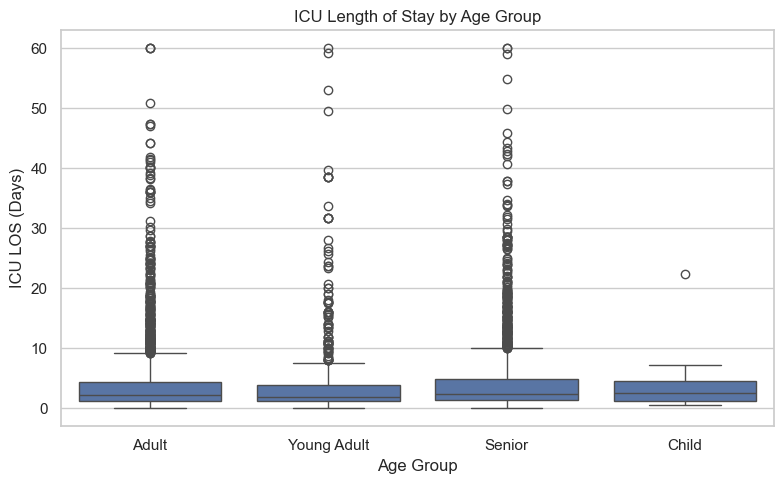

In [64]:
# ICU Length of Stay by Age Group
plt.figure(figsize=(8, 5))
sns.boxplot(x="AGE_GROUP", y="ICU_LOS", data=df_plot)
plt.title("ICU Length of Stay by Age Group")
plt.xlabel("Age Group")
plt.ylabel("ICU LOS (Days)")
plt.tight_layout()
plt.show()

/var/folders/k4/8yy8wb052bz4q0y3xvcpc62w0000gn/T/ipykernel_61566/3136110601.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Expired (1 = Yes)")


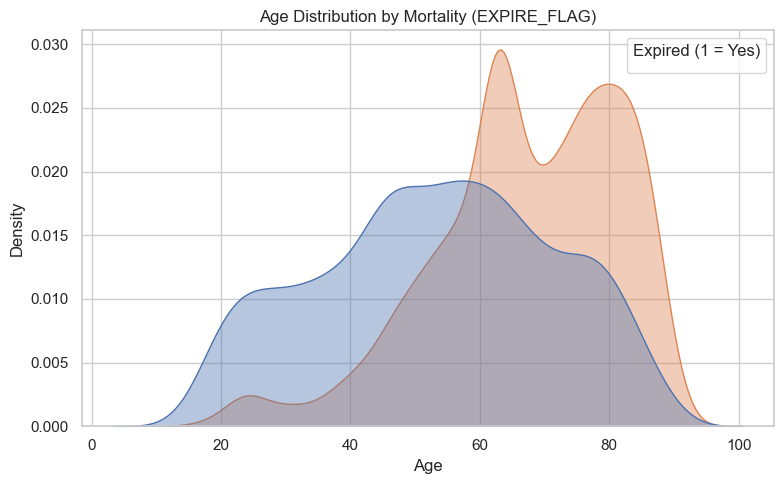

In [65]:
# Age Distribution by Mortality
plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_plot, x="AGE", hue="EXPIRE_FLAG", fill=True, common_norm=False, alpha=0.4)
plt.title("Age Distribution by Mortality (EXPIRE_FLAG)")
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend(title="Expired (1 = Yes)")
plt.tight_layout()
plt.show()


#### Age vs ICU Stay Length

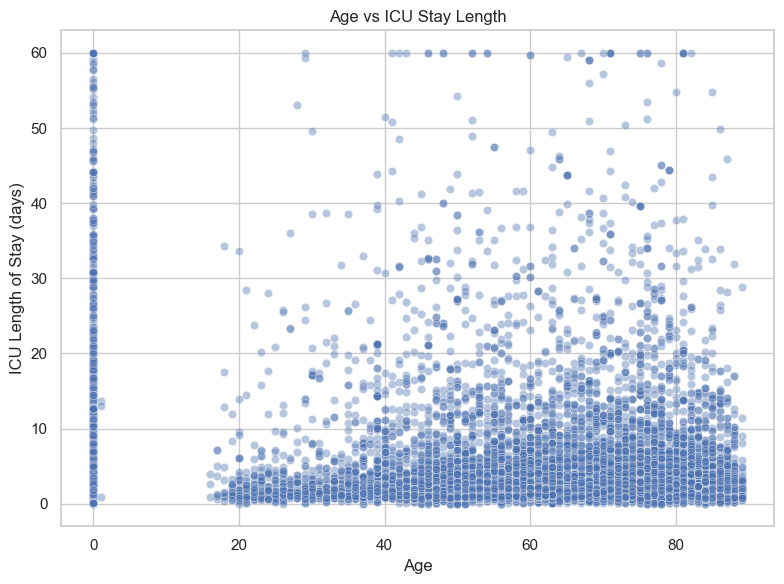

In [66]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x="AGE", y="ICU_LOS", alpha=0.4)
plt.title("Age vs ICU Stay Length")
plt.xlabel("Age")
plt.ylabel("ICU Length of Stay (days)")
plt.tight_layout()
plt.show()

#### ICU Stay Length vs Mortality

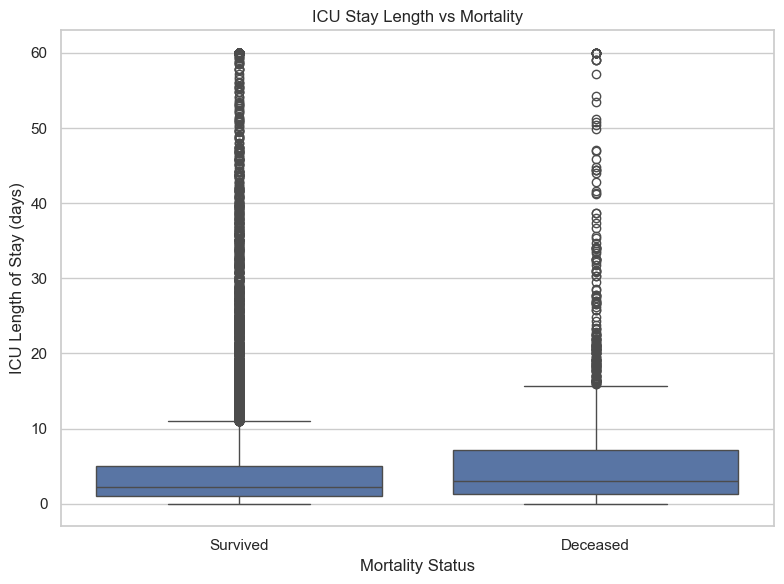

In [67]:
plt.figure(figsize=(8, 6))
sns.boxplot(x="MORTALITY", y="ICU_LOS", data=data)
plt.xticks([0, 1], ["Survived", "Deceased"])
plt.title("ICU Stay Length vs Mortality")
plt.xlabel("Mortality Status")
plt.ylabel("ICU Length of Stay (days)")
plt.tight_layout()
plt.show()

#### Mortality rate vs Age Group

In [68]:
def age_bucket(age):
    if age < 18:
        return "Child"
    elif age < 40:
        return "Young Adult"
    elif age < 65:
        return "Adult"
    else:
        return "Senior"

data["AGE_GROUP"] = data["AGE"].apply(age_bucket)

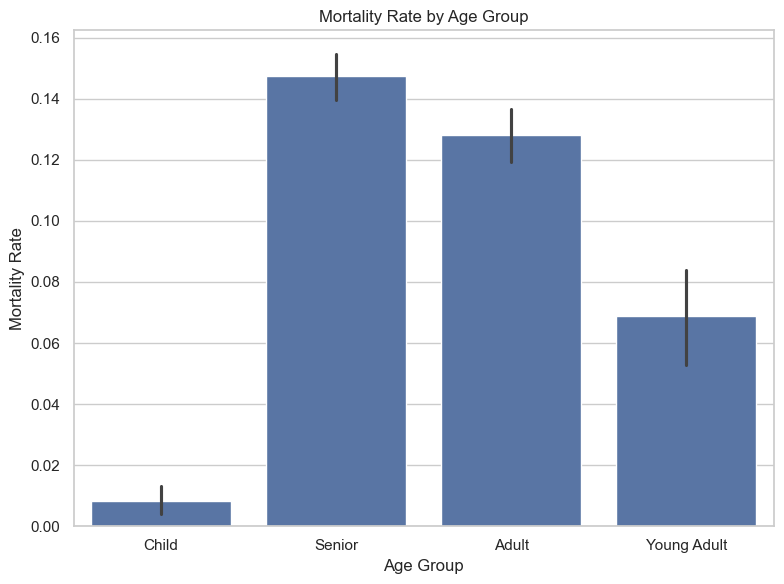

In [69]:
plt.figure(figsize=(8, 6))
sns.barplot(data=data, x="AGE_GROUP", y="MORTALITY")
plt.title("Mortality Rate by Age Group")
plt.ylabel("Mortality Rate")
plt.xlabel("Age Group")
plt.tight_layout()
plt.show()


#### Mortality Rate vs Gender and Ethnicity

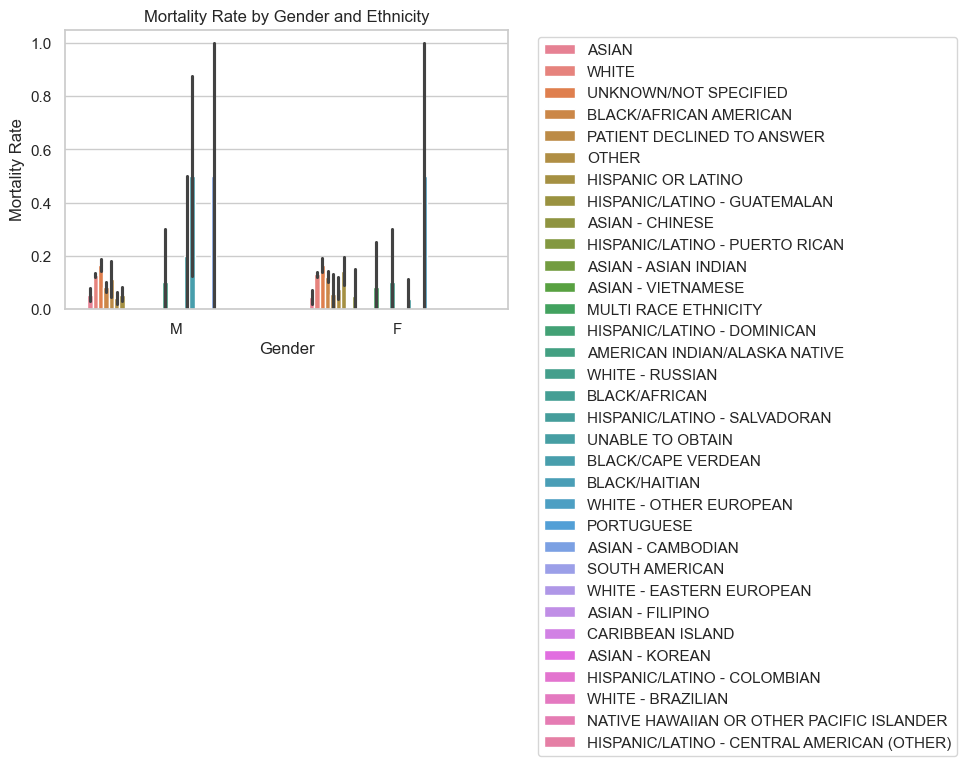

In [70]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x="GENDER", y="MORTALITY", hue="ETHNICITY")
plt.title("Mortality Rate by Gender and Ethnicity")
plt.ylabel("Mortality Rate")
plt.xlabel("Gender")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### Mortality Rate vs ICU Unit

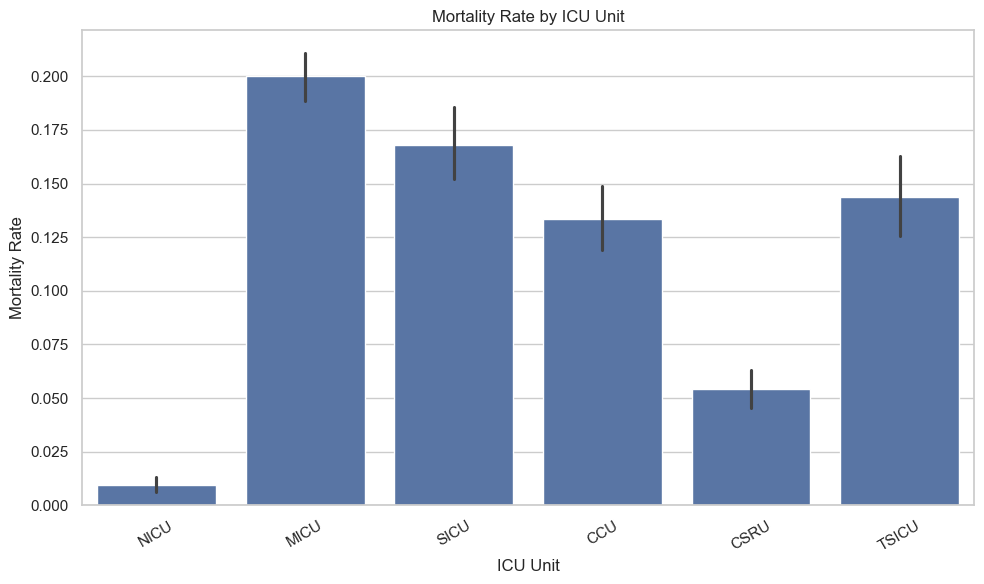

In [71]:
plt.figure(figsize=(10, 6))
sns.barplot(data=data, x="FIRST_CAREUNIT", y="MORTALITY")
plt.title("Mortality Rate by ICU Unit")
plt.xlabel("ICU Unit")
plt.ylabel("Mortality Rate")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


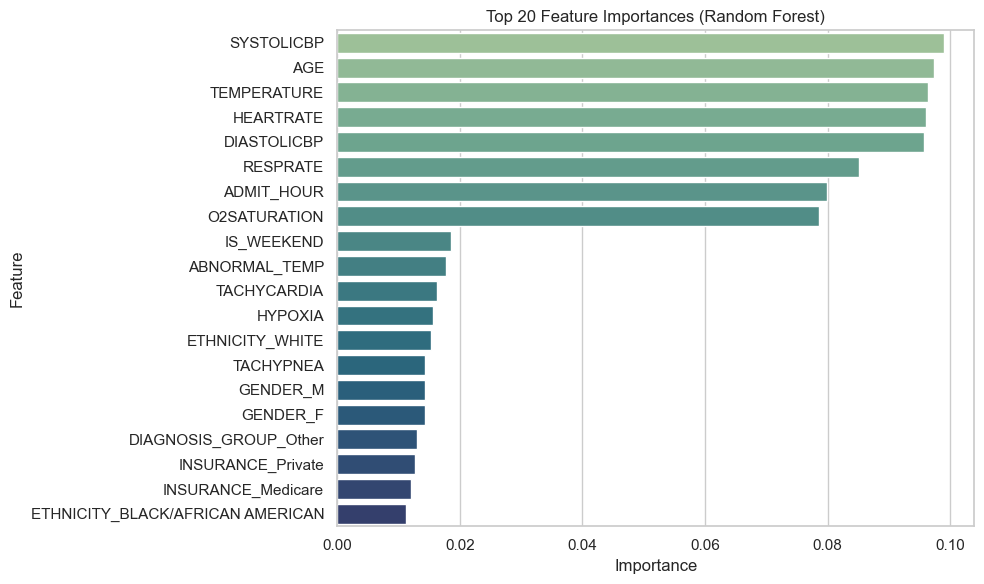

In [131]:
df = pd.read_csv("MERGED_DATA_cleaned_final1.csv", low_memory=False)
# Feature Engineering
df["IS_WEEKEND"] = df["ADMIT_DAYOFWEEK"].isin(["Saturday", "Sunday"]).astype(int)
df["ABNORMAL_TEMP"] = df["TEMPERATURE"].apply(lambda x: 1 if x > 101 or x < 96 else 0)
df["TACHYCARDIA"] = df["HEARTRATE"].apply(lambda x: 1 if x > 100 else 0)
df["TACHYPNEA"] = df["RESPRATE"].apply(lambda x: 1 if x > 20 else 0)
df["HYPOXIA"] = df["O2SATURATION"].apply(lambda x: 1 if x < 92 else 0)
df["HYPOTENSION"] = df.apply(lambda row: 1 if row["SYSTOLICBP"] < 90 or row["DIASTOLICBP"] < 60 else 0, axis=1)
top_diags = df["DIAGNOSIS"].value_counts().nlargest(10).index
df["DIAGNOSIS_GROUP"] = df["DIAGNOSIS"].apply(lambda x: x if x in top_diags else "Other")
df["RISK_LEVEL"] = df["LOS_DAYS"].apply(lambda days: "Low" if days <= 2 else ("Medium" if days <= 5 else "High"))

features = [
    "AGE", "GENDER", "ADMISSION_TYPE", "ETHNICITY", "INSURANCE", "ADMIT_HOUR",
    "IS_WEEKEND", "ABNORMAL_TEMP", "TACHYCARDIA", "TACHYPNEA", "HYPOXIA", "HYPOTENSION",
    "HEARTRATE", "RESPRATE", "O2SATURATION", "TEMPERATURE", "SYSTOLICBP", "DIASTOLICBP",
    "DIAGNOSIS_GROUP"
]    # Selecting features and target

X = df[features]
y = df["RISK_LEVEL"]

le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)
categorical = ["GENDER", "ADMISSION_TYPE", "ETHNICITY", "INSURANCE", "DIAGNOSIS_GROUP"]
preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
], remainder="passthrough")

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators=100, random_state=42))
])
model.fit(X_train, y_train)

ohe = model.named_steps["preprocessor"].named_transformers_["cat"]
ohe_feature_names = ohe.get_feature_names_out(categorical)
numerical_features = [f for f in X.columns if f not in categorical]
all_features = list(ohe_feature_names) + numerical_features
importances = model.named_steps["classifier"].feature_importances_
importance_df = pd.DataFrame({"Feature": all_features, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False).head(20)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, y="Feature", x="Importance", palette="crest")
plt.title("Top 20 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

# MODEL TRAINING

## Admission Prediction

In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [74]:
features = ['AGE', 'GENDER', 'HEARTRATE', 'RESPRATE', 'O2SATURATION',
            'TEMPERATURE', 'SYSTOLICBP', 'DIASTOLICBP', 'DIAGNOSIS']
target = 'EXPIRE_FLAG'
df = pd.read_csv("MERGED_DATA_cleaned_final1.csv")
df = df[features + [target]].dropna()
label_encoders = {} # # Encoding categorical columns
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [75]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #splitting data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [76]:
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=50, max_depth=3, random_state=42)

models = {
    "Logistic Regression": (lr, X_train_scaled, X_test_scaled),
    "Random Forest": (rf, X_train, X_test),
    "XGBoost": (xgb, X_train, X_test)
}

In [77]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("\n----- 10-Fold Cross-Validation Results -----")
for name, (model, X_tr, _) in models.items():
    scores = cross_val_score(model, X_tr, y_train, cv=skf, scoring='f1')
    print(f"{name}: Mean F1 Score = {scores.mean():.4f}")


----- 10-Fold Cross-Validation Results -----
Logistic Regression: Mean F1 Score = 0.7267
Random Forest: Mean F1 Score = 0.8178
XGBoost: Mean F1 Score = 0.7461


In [78]:
lr.fit(X_train_scaled, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)


----- Test Set Evaluation -----

Logistic Regression:
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       463
           1       0.70      0.77      0.73       566

    accuracy                           0.69      1029
   macro avg       0.69      0.68      0.68      1029
weighted avg       0.69      0.69      0.69      1029

ROC AUC Score: 0.729


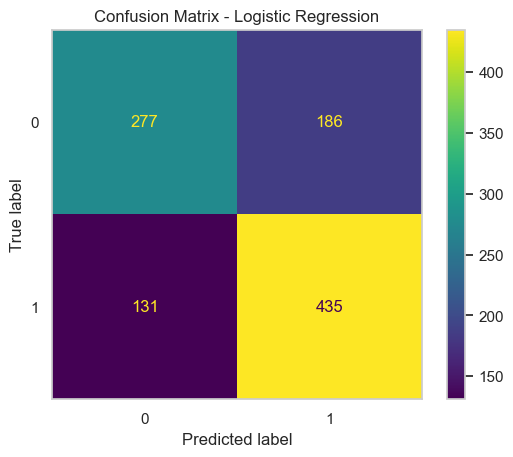


Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       463
           1       0.82      0.84      0.83       566

    accuracy                           0.81      1029
   macro avg       0.81      0.81      0.81      1029
weighted avg       0.81      0.81      0.81      1029

ROC AUC Score: 0.866


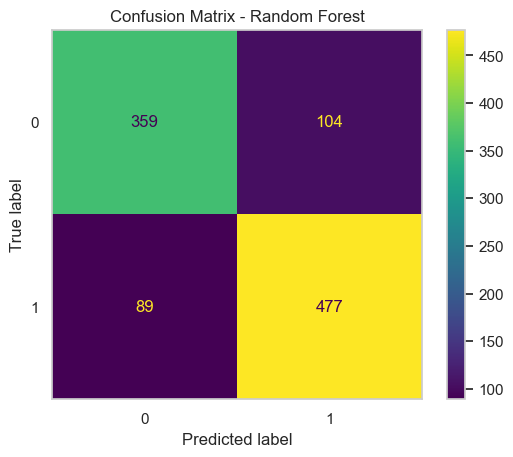


XGBoost:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       463
           1       0.72      0.77      0.74       566

    accuracy                           0.70      1029
   macro avg       0.70      0.70      0.70      1029
weighted avg       0.70      0.70      0.70      1029

ROC AUC Score: 0.77


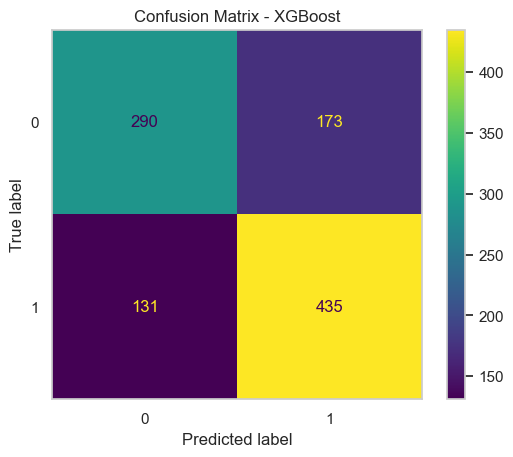

In [82]:
print("\n----- Test Set Evaluation -----")
for name, (model, _, X_eval) in models.items():
    y_pred = model.predict(X_eval)
    y_prob = model.predict_proba(X_eval)[:, 1]
    
    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", round(roc_auc_score(y_test, y_prob), 3))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(ax=ax, cmap='viridis', colorbar=True)
    ax.grid(False)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [97]:
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [83]:
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=50, max_depth=3, random_state=42)

models = {
    "Logistic Regression": (lr, X_train_scaled, X_test_scaled),
    "Random Forest": (rf, X_train, X_test),
    "XGBoost": (xgb, X_train, X_test)
}

In [84]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
print("\n----- 10-Fold Cross-Validation Results -----")
for name, (model, X_tr, _) in models.items():
    scores = cross_val_score(model, X_tr, y_train, cv=skf, scoring='f1')
    print(f"{name}: Mean F1 Score = {scores.mean():.4f}")


----- 10-Fold Cross-Validation Results -----
Logistic Regression: Mean F1 Score = 0.7267
Random Forest: Mean F1 Score = 0.8178
XGBoost: Mean F1 Score = 0.7461


In [85]:
lr.fit(X_train_scaled, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)


----- Test Set Evaluation -----

Logistic Regression:
              precision    recall  f1-score   support

           0       0.69      0.54      0.60       482
           1       0.66      0.78      0.71       547

    accuracy                           0.67      1029
   macro avg       0.67      0.66      0.66      1029
weighted avg       0.67      0.67      0.66      1029

ROC AUC Score: 0.706


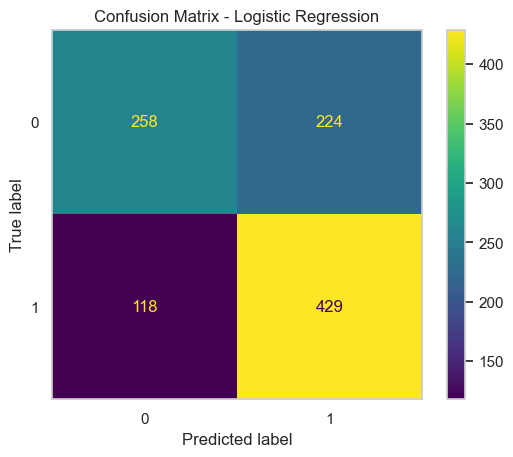


Random Forest:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       482
           1       0.80      0.84      0.82       547

    accuracy                           0.81      1029
   macro avg       0.81      0.81      0.81      1029
weighted avg       0.81      0.81      0.81      1029

ROC AUC Score: 0.863


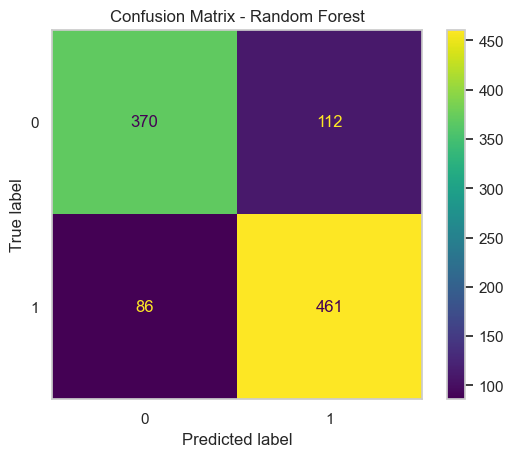


XGBoost:
              precision    recall  f1-score   support

           0       0.72      0.57      0.64       482
           1       0.68      0.81      0.74       547

    accuracy                           0.69      1029
   macro avg       0.70      0.69      0.69      1029
weighted avg       0.70      0.69      0.69      1029

ROC AUC Score: 0.745


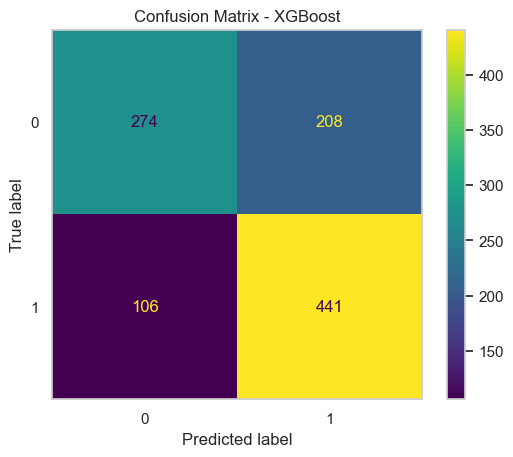

In [94]:
print("\n----- Test Set Evaluation -----")
for name, (model, X_eval) in models.items():
    y_pred = model.predict(X_eval)
    y_prob = model.predict_proba(X_eval)[:, 1]

    print(f"\n{name}:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", round(roc_auc_score(y_test, y_prob), 3))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots()
    disp.plot(ax=ax, cmap='viridis', colorbar=True)
    ax.grid(False)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()



In [95]:
df = pd.read_csv("MERGED_DATA_cleaned_final1.csv")
features = [
    'AGE', 'GENDER', 'HEARTRATE', 'RESPRATE',
    'O2SATURATION', 'TEMPERATURE', 'SYSTOLICBP', 'DIASTOLICBP', 'DIAGNOSIS'
]
target = 'EXPIRE_FLAG'
df = df[features + [target]].dropna()
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [96]:
# Splitting into train/test
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [97]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [98]:
lr = LogisticRegression(max_iter=1000)
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=50, max_depth=3, random_state=42)
lr.fit(X_train_scaled, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)

In [99]:
models = {
    "Logistic Regression": (lr, X_test_scaled),
    "Random Forest": (rf, X_test),
    "XGBoost": (xgb, X_test)
}

for name, (model, X_eval) in models.items():
    y_pred = model.predict(X_eval)
    y_prob = model.predict_proba(X_eval)[:, 1]
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", round(roc_auc_score(y_test, y_prob), 3))


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.69      0.54      0.60       482
           1       0.66      0.78      0.71       547

    accuracy                           0.67      1029
   macro avg       0.67      0.66      0.66      1029
weighted avg       0.67      0.67      0.66      1029

ROC AUC Score: 0.706

Random Forest Results:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       482
           1       0.80      0.84      0.82       547

    accuracy                           0.81      1029
   macro avg       0.81      0.81      0.81      1029
weighted avg       0.81      0.81      0.81      1029

ROC AUC Score: 0.863

XGBoost Results:
              precision    recall  f1-score   support

           0       0.72      0.57      0.64       482
           1       0.68      0.81      0.74       547

    accuracy                           0.69      1029
   macro avg  

In [100]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
joblib.dump(rf_model, "random_forest_model.pkl")
joblib.dump(label_encoders, "rf_label_encoders.pkl")
print("Model and encoders saved.")

Model and encoders saved.


## Length of stay prediction if admitted

In [101]:
df = pd.read_csv("MERGED_DATA_cleaned_final1.csv")
df_admitted = df[df["EXPIRE_FLAG"] == 1].copy()
df_admitted = df_admitted[df_admitted["LOS_DAYS"] > 0].copy()
df_admitted["LOS_DAYS"] = df_admitted["LOS_DAYS"].clip(upper=30)
df_admitted["LOG_LOS"] = np.log1p(df_admitted["LOS_DAYS"])  # log(1 + LOS_DAYS)

In [102]:
# Features for LOS prediction
features = [
    'AGE', 'GENDER', 'HEARTRATE', 'RESPRATE',
    'O2SATURATION', 'TEMPERATURE', 'SYSTOLICBP',
    'DIASTOLICBP', 'DIAGNOSIS'
]

df_admitted = df_admitted[features + ["LOG_LOS"]].dropna()

label_encoders = {}
for col in df_admitted.select_dtypes(include="object").columns:
    le = LabelEncoder()
    df_admitted[col] = le.fit_transform(df_admitted[col])
    label_encoders[col] = le

In [103]:
X = df_admitted[features]
y = df_admitted["LOG_LOS"]



los_model = RandomForestRegressor(n_estimators=100, random_state=42)
los_model.fit(X_train, y_train)


joblib.dump(los_model, "los_model.pkl")
joblib.dump(label_encoders, "los_label_encoders.pkl")

print("LOS model trained and saved as 'los_model.pkl'")

LOS model trained and saved as 'los_model.pkl'


## Classifying Patients into risk levels

In [104]:
features = ['AGE', 'GENDER', 'HEARTRATE', 'RESPRATE', 'O2SATURATION', 'TEMPERATURE', 'SYSTOLICBP', 'DIASTOLICBP', 'DIAGNOSIS']
target = 'EXPIRE_FLAG'

df = df[features + [target]].dropna()
label_encoders = {} # Encoding categorical
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [105]:
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
y_proba = rf_clf.predict_proba(X_test)[:, 1]

In [106]:
def classify_risk(p):
    if p < 0.4:
        return "Low"
    elif p < 0.7:
        return "Medium"
    else:
        return "High"

risk_levels = [classify_risk(p) for p in y_proba]

In [108]:
from collections import Counter
y_pred = rf_clf.predict(X_test)
print("\n Binary Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_proba), 3))
print("\n Risk Level Distribution:")
print(Counter(risk_levels))


 Binary Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       482
           1       0.80      0.84      0.82       547

    accuracy                           0.81      1029
   macro avg       0.81      0.81      0.81      1029
weighted avg       0.81      0.81      0.81      1029

ROC AUC Score: 0.863

 Risk Level Distribution:
Counter({'Low': 371, 'High': 342, 'Medium': 316})


## Nlp Analysis

In [114]:
NOTEEVENTS = pd.read_csv("NOTEEVENTS.csv")

In [110]:
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

df = pd.read_csv("NOTEEVENTS.csv", nrows=500)

def clean_notes(texts):
    docs = nlp.pipe(texts)
    return [
        " ".join([token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct])
        for doc in docs
    ]

df["clean_text"] = clean_notes(df["TEXT"].astype(str).tolist())

vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(df["clean_text"])

svd = TruncatedSVD(n_components=50)
X_reduced = svd.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(X_reduced)

print("Clustering complete.")

Clustering complete.


In [115]:
def clean_text(text):
    if isinstance(text, str):
        text = re.sub(r"\[\*\*.*?\*\*\]", " ", text)  # removing de-identified parts like [**NAME**]
        text = re.sub(r"[^a-zA-Z\s]", " ", text)  # removing punctuation, keeping only letters
        text = text.lower()
        text = text.replace("\n", " ")

        return text
    else:
        return ""
NOTEEVENTS["cleaned_text"] = NOTEEVENTS["TEXT"].apply(clean_text)
print(NOTEEVENTS[["TEXT", "cleaned_text"]].head())

                                                TEXT  \
0  Neonatology Attending Triage Note\n\nBaby [**N...   
1  Nursing Transfer note\n\n\nPt admitted to NICU...   
2  Sinus rhythm\nInferior/lateral ST-T changes ar...   
3  [**2101-10-26**] 6:01 AM\n CHEST (PORTABLE AP)...   
4  Sinus rhythm\nA-V delay\nNonspecific inferior ...   

                                        cleaned_text  
0  neonatology attending triage note  baby     is...  
1  nursing transfer note   pt admitted to nicu fo...  
2  sinus rhythm inferior lateral st t changes are...  
3         am  chest  portable ap                 ...  
4  sinus rhythm a v delay nonspecific inferior t ...  


In [122]:
admissions = pd.read_csv("ADMISSIONS.csv")
NOTEEVENTS["cleaned_text"] = NOTEEVENTS["TEXT"].apply(clean_text)
NOTEEVENTS = NOTEEVENTS.merge(admissions[["SUBJECT_ID", "HADM_ID", "HOSPITAL_EXPIRE_FLAG"]],
                              on=["SUBJECT_ID", "HADM_ID"], how="left")
NOTEEVENTS = NOTEEVENTS.dropna(subset=["cleaned_text", "HOSPITAL_EXPIRE_FLAG"])
X = NOTEEVENTS["cleaned_text"]
y = NOTEEVENTS["HOSPITAL_EXPIRE_FLAG"]
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_tfidf = vectorizer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.90      0.99      0.94     76012
         1.0       0.73      0.24      0.36     10487

    accuracy                           0.90     86499
   macro avg       0.82      0.61      0.65     86499
weighted avg       0.88      0.90      0.87     86499



In [123]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')

In [124]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)

In [126]:
import xgboost as xgb
ratio = (y == 0).sum() / (y == 1).sum()
model = xgb.XGBClassifier(scale_pos_weight=ratio, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [128]:
print("Loading data...")
df = pd.read_csv("NOTEEVENTS.csv").dropna(subset=["TEXT"]).head(3000)
print(" Loading NLP model...")
nlp = spacy.load("en_core_web_sm")

def clean_note(text):
    doc = nlp(str(text))
    tokens = []
    for token in doc:
        word = token.lemma_.lower()
        if token.is_stop or token.is_punct or token.like_num:
            continue
        if re.match(r"^\d+[a-z]*$", word): 
            continue
        tokens.append(word)
    return " ".join(tokens)

print("Preprocessing 3000 clinical notes...")
df["clean_text"] = df["TEXT"].apply(clean_note)

Loading data...
 Loading NLP model...
Preprocessing 3000 clinical notes...


In [129]:
print("Vectorizing text...")
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df["clean_text"])
print(" Reducing dimensions...")
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X)
print(" Clustering into topics...")
kmeans = KMeans(n_clusters=5, random_state=42)
df["cluster"] = kmeans.fit_predict(X_reduced)

Vectorizing text...
 Reducing dimensions...
 Clustering into topics...


In [130]:
print("\n Top keywords per cluster (excluding numeric tokens):")
terms = vectorizer.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(5):
    print(f"\nCluster {i + 1}:")
    keywords = []
    for ind in order_centroids[i]:
        word = terms[ind]
        if not re.match(r"^\d+[a-z]*$", word):  # filter numeric-like terms
            keywords.append(word)
        if len(keywords) == 10:
            break
    print(", ".join(keywords))


 Top keywords per cluster (excluding numeric tokens):

Cluster 1:
able, advance, acute, abscess, abdomen, abg, alt, addendum, abdominal, alert

Cluster 2:
abnormal, abx, ad, abd, active, activity, admit, arterial, aware, antibiotic

Cluster 3:
abx, abg, adequate, abnormal, add, antibiotic, abdominal, abscess, additional, appear

Cluster 4:
abd, abx, afternoon, ago, abg, abnormality, able, ascite, addendum, access

Cluster 5:
abnormality, advance, admission, abscess, afof, available, adrenal, able, abdomen, active
